# Tutorial 2 - Layer Types

In this tutorial we will be re-using the code introduced in the first tutorial and explore different KAN layer types.

In [1]:
from jaxkan.models.KAN import KAN

import jax
import jax.numpy as jnp

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from flax import nnx
import optax

import matplotlib.pyplot as plt
import numpy as np

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

## Experiment Setup

Working with the exact same setup as in the previous tutorial, we define all necessary functions here.

In [2]:
def f(x,y):
    return x**2 + 2*jnp.exp(y)

def generate_data(minval=-1, maxval=1, num_samples=1000, seed=42):
    key = jax.random.PRNGKey(seed)
    x_key, y_key = jax.random.split(key)

    x1 = jax.random.uniform(x_key, shape=(num_samples,), minval=minval, maxval=maxval)
    x2 = jax.random.uniform(y_key, shape=(num_samples,), minval=minval, maxval=maxval)

    y = f(x1, x2).reshape(-1, 1)
    X = jnp.stack([x1, x2], axis=1)
    
    return X, y

seed = 42

X, y = generate_data(minval=-1, maxval=1, num_samples=1000, seed=seed)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

# Define the static parameters
n_in = X_train.shape[1]
n_out = y_train.shape[1]
n_hidden = 6

layer_dims = [n_in, n_hidden, n_hidden, n_out]

Training set size: (800, 2)
Test set size: (200, 2)


We will define a function that incorporates all the aspects seen in the previous tutorial: model definition, training and evaluation. The input of the function will be `layer_type` and `required_parameters`, so that we can focus on these aspects in the present tutorial.

In [3]:
def run_experiment(layer_type, required_parameters):

    # Initialize a KAN model, depending on the inputs of the experiment
    model = KAN(layer_dims = layer_dims,
                layer_type = layer_type,
                required_parameters = required_parameters,
                seed = 42
               )

    # Define Optimizer
    opt_type = optax.adam(learning_rate=0.001)
    optimizer = nnx.Optimizer(model, opt_type, wrt=nnx.Param)

    # Define train loop
    @nnx.jit
    def train_step(model, optimizer, X_train, y_train):
    
        def loss_fn(model):
            residual = model(X_train) - y_train
            loss = jnp.mean((residual)**2)
    
            return loss
        
        loss, grads = nnx.value_and_grad(loss_fn)(model)
        optimizer.update(model, grads)
        
        return loss

    # Do training
    num_epochs = 2000
    train_losses = jnp.zeros((num_epochs,))
    
    for epoch in range(num_epochs):
        # Calculate the loss
        loss = train_step(model, optimizer, X_train, y_train)
        
        # Append the loss
        train_losses = train_losses.at[epoch].set(loss)

    # Get MSE on test set
    y_pred = model(X_test)
    mse = mean_squared_error(y_test, y_pred)

    print(f"The MSE of the fit is {mse:.5f}\n\n")

    # Plot Losses
    plt.figure(figsize=(7, 4))

    plt.plot(np.array(train_losses), label='Train Loss', marker='o', color='#25599c', markersize=1)
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.yscale('log')
    
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5) 
    
    plt.show()

    return

## Experiments

We will then run this function with different layer types to showcase how they can be defined. Note that the results obtained in these experiments are not indicative of which layer "performs better"; we have defined a certain architecture, with specific optimization settings, with the goal of fitting a specific function. Results will definitely vary in other setups.

### Base Layer

The `base` layer corresponds to the original KAN implementation, as presented in [KAN: Kolmogorov–Arnold Networks](https://openreview.net/forum?id=Ozo7qJ5vZi). The parameters that can be input via the `required_parameters` argument are:

- `k`: The order of the spline basis functions.
- `G`: The number of intervals for each spline grid.
- `grid_range`: An initial range for the grids' ends.
- `grid_e`: Parameter within the [0.0, 1.0] range that defines if the layer grids are uniform or sample-dependent.
- `residual`: Function that is applied on samples to calculate residual activation.
- `external_weights`: Boolean that controls if additional trainable weights should be applied to the splines.
- `init_scheme`: Dictionary that defines how the trainable parameters of each layer are initialized.
- `add_bias`: Boolean that controls wether bias terms are also included during the forward pass or not.

More information and example usage for these can be found in the API Reference.

In [4]:
layer_type = "base"

required_parameters = {'k': 3, 'G': 5,
                       'grid_range': (-1,1), 'grid_e': 1.0,
                       'residual': None, 'external_weights': False,
                       'init_scheme': {"type" : "default"},
                       'add_bias': True}

The MSE of the fit is 0.00029




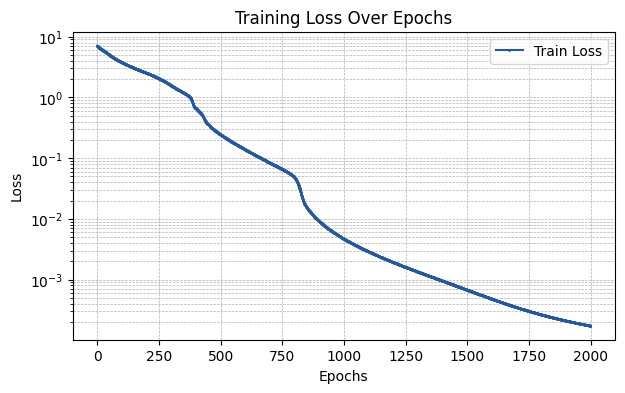

In [5]:
run_experiment(layer_type, required_parameters)

### Spline Layer

The `spline` layer corresponds to the efficiently-implemented KAN, as introduced in [An Efficient Implementation of Kolmogorov-Arnold Network](https://github.com/Blealtan/efficient-kan). The parameters that can be input via the `required_parameters` argument are the same as in the `base` case.

In [6]:
layer_type = "spline"

required_parameters = {'k': 3, 'G': 5,
                       'grid_range': (-1,1), 'grid_e': 1.0,
                       'residual': None, 'external_weights': False,
                       'init_scheme': {"type" : "default"},
                       'add_bias': True}

The MSE of the fit is 0.00029




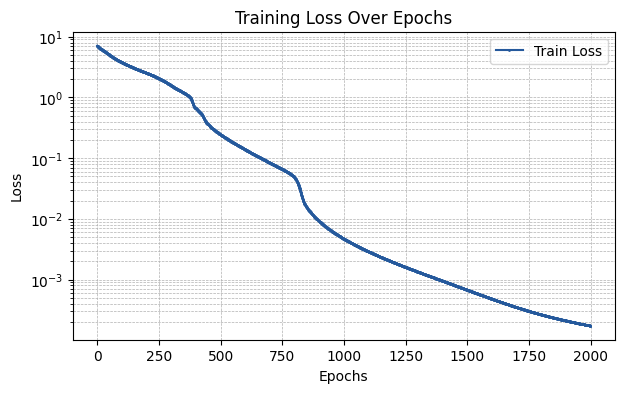

In [7]:
run_experiment(layer_type, required_parameters)

### Chebyshev Layer

The `chebyshev` layer utilizes Chebyshev polynomials of the first type as basis functions. The parameters that can be input via the `required_parameters` argument are:

- `D`: Degree of Chebyshev polynomials to be used.
- `flavor`: One of "default", "modified", or "exact" - controls how the basis functions are applied (more information about this can be found in the API Reference).
- `residual`: Same as in `base`.
- `external_weights`: Same as in `base`.
- `init_scheme`: Same as in `base`.
- `add_bias`: Same as in `base`.

In [8]:
layer_type = "chebyshev"

required_parameters = {'D': 5, 'flavor': 'exact',
                       'residual': None, 'external_weights': False,
                       'init_scheme': {"type" : "default"},
                       'add_bias': True}

The MSE of the fit is 0.00563




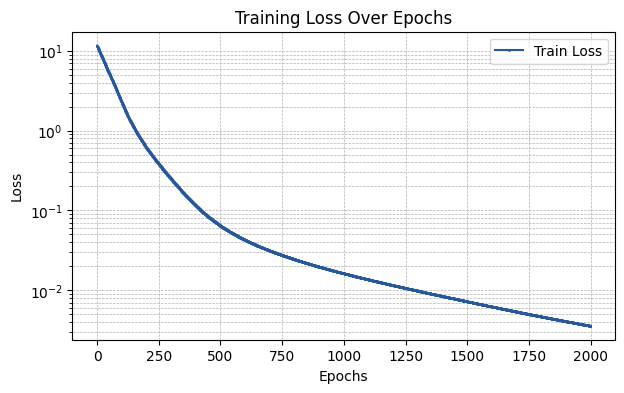

In [9]:
run_experiment(layer_type, required_parameters)

### Legendre Layer

The `legendre` layer utilizes Legendre polynomials as basis functions. The parameters that can be input via the `required_parameters` argument are the same as in the `chebyshev` case.

In [10]:
layer_type = "legendre"

required_parameters = {'D': 5, 'flavor': 'exact',
                       'residual': None, 'external_weights': False,
                       'init_scheme': {"type" : "default"},
                       'add_bias': True}

The MSE of the fit is 0.00582




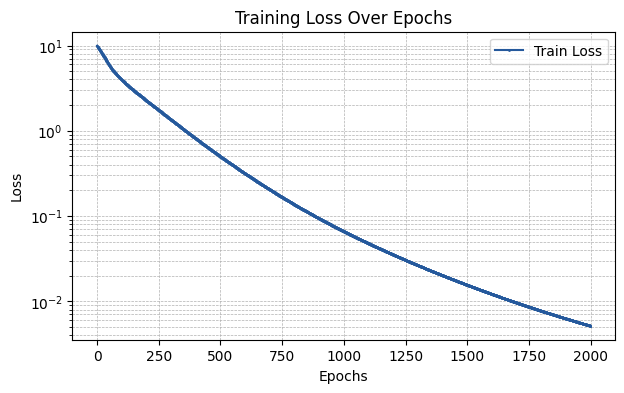

In [11]:
run_experiment(layer_type, required_parameters)

### Fourier Layer

The `fourier` layer utilizes cosines and sines as basis functions. The parameters that can be input via the `required_parameters` argument are:

- `D`: Order of the Fourier sum.
- `smooth_init`: Boolean that controls if Fourier coefficients are initialized with smoothening.
- `add_bias`: Same as in the other layer types.

In [12]:
layer_type = "fourier"

required_parameters = {'D': 5, 'smooth_init': True, 'add_bias': True}

The MSE of the fit is 0.00120




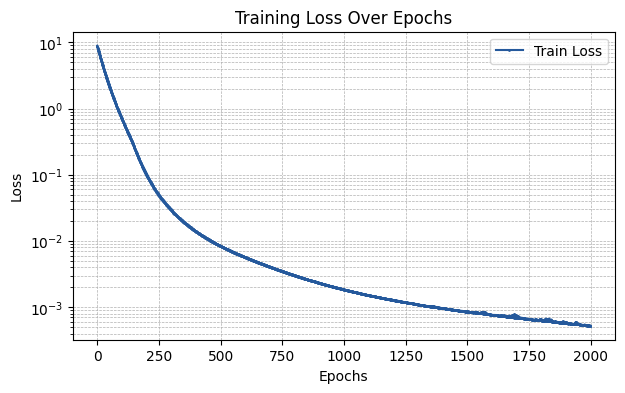

In [13]:
run_experiment(layer_type, required_parameters)

### RBF Layer

The `rbf` layer utilizes different radial functions as basis functions. The parameters that can be input via the `required_parameters` argument are:

- `D`: Number of basis functions.
- `kernel`: Kernel to be used for the RBFs (e.g., "gaussian").
- `grid_range`: Same as in `base`.
- `grid_e`: Same as in `base`.
- `residual`: Same as in `base`.
- `external_weights`: Same as in `base`.
- `init_scheme`: Same as in `base`.
- `add_bias`: Same as in `base`.

In [14]:
layer_type = "rbf"

required_parameters = {'D': 5, 'kernel': {"type" : "gaussian"},
                       'grid_range': (-1,1), 'grid_e': 1.0,
                       'residual': None, 'external_weights': False,
                       'init_scheme': {"type" : "default"},
                       'add_bias': True}

The MSE of the fit is 0.00337




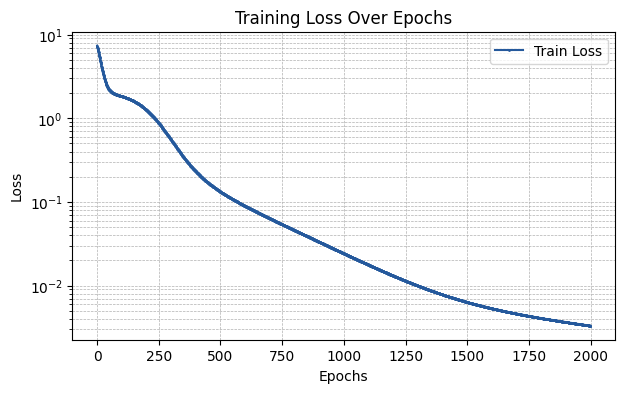

In [15]:
run_experiment(layer_type, required_parameters)

### Sine Layer

The `sine` layer utilizes sine-based basis functions as introduced in [Deep Learning Alternatives Of The Kolmogorov Superposition Theorem
](https://openreview.net/forum?id=SyVPiehSbg). The parameters that can be input via the `required_parameters` argument are:

- `D`: Number of basis functions.
- `residual`: Same as in `base`.
- `external_weights`: Same as in `base`.
- `init_scheme`: Same as in `base`.
- `add_bias`: Same as in `base`.

In [16]:
layer_type = "sine"

required_parameters = {'D': 5,
                       'residual': None, 'external_weights': False,
                       'init_scheme': {"type" : "default"},
                       'add_bias': True}

The MSE of the fit is 0.00083




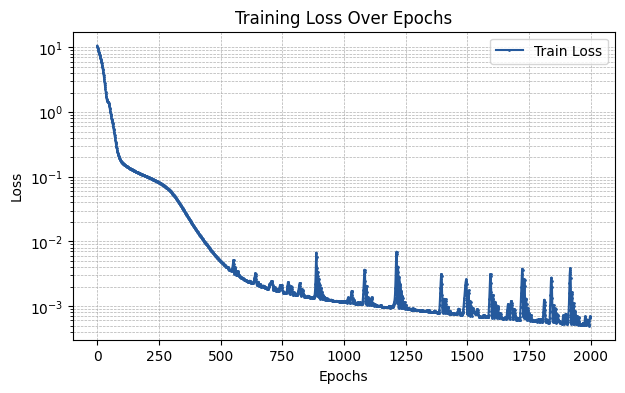

In [17]:
run_experiment(layer_type, required_parameters)